<a href="https://colab.research.google.com/github/shreyansh-21/LumaPlate/blob/main/License_Plate_Recognition_and_Image_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytesseract
!pip install opencv-python
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import pytesseract
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400

In [ ]:
train_low_light_images = sorted(glob("/content/drive/MyDrive/lol_dataset/lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("/content/drive/MyDrive/lol_dataset/lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]


In [ ]:
def load_data(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels = 3)
  image = tf.image.resize(images= image,size=[IMAGE_SIZE,IMAGE_SIZE])
  image = image/255.0
  return image

def data_genrator(low_light_images):
  dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
  dataset = dataset.map(load_data,num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE,drop_remainder = True)
  return dataset


In [ ]:
train_dataset = data_genrator(train_low_light_images)
val_dataset = data_genrator(val_low_light_images)

print("Train Dataset: ",train_dataset)
print("Validation Dataset: ",val_dataset)

Train Dataset:  <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset:  <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


In [ ]:
def build_dce_net():
  input_img = keras.Input(shape=[None,None,3])
  conv1 = layers.Conv2D(
      32, (3,3) ,strides=(1,1), activation="relu",padding="same"
  )(input_img)
  conv2 = layers.Conv2D(
      32, (3,3) ,strides=(1,1), activation="relu",padding="same"
  )(conv1)
  conv3 = layers.Conv2D(
      32, (3,3) ,strides=(1,1), activation="relu",padding="same"
  )(conv2)
  conv4 = layers.Conv2D(
      32, (3,3) ,strides=(1,1), activation="relu",padding="same"
  )(conv3)
  int_con1 = layers.Concatenate(axis = -1)([conv4,conv3])
  conv5 = layers.Conv2D(
      32, (3,3) ,strides=(1,1), activation="relu",padding="same"
  )(int_con1)
  int_con2 = layers.Concatenate(axis = -1)([conv5,conv2])
  conv6 = layers.Conv2D(
      32, (3,3) ,strides=(1,1), activation="relu",padding="same"
  )(int_con2)
  int_con3 = layers.Concatenate(axis = -1)([conv6,conv1])
  x_r = layers.Conv2D(24, (3,3), strides = (1,1), activation="tanh", padding = "same")(
      int_con3
  )
  return keras.Model(inputs= input_img, outputs=x_r)



In [ ]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]

    d_rg = tf.square(mr - mg)
    d_gb = tf.square(mg - mb)
    d_br = tf.square(mb - mr)

    return tf.reduce_mean(d_rg + d_gb + d_br)

In [ ]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))


In [ ]:
def illumination_smoothness_loss(x):
  batch_size =tf.shape(x)[0]
  h_x = tf.shape(x)[1]
  w_x = tf.shape(x)[2]
  count_h = (tf.shape(x)[2]-1)*tf.shape(x)[3]
  count_w = tf.shape(x)[2]* (tf.shape(x)[3]-1)
  h_tv = tf.reduce_sum(tf.square((x[:,1:,:,:] - x[:,:h_x-1,:,:])))
  w_tv = tf.reduce_sum(tf.square((x[:,:,1:,:] - x[:,:,:w_x-1,:])))
  batch_size = tf.cast(count_h,dtype=tf.float32)
  count_h = tf.cast(count_h,dtype=tf.float32)
  count_w = tf.cast(count_w,dtype=tf.float32)
  return 2*(h_tv/count_h + w_tv/count_w)/batch_size


In [ ]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0,0,0]],[[-1,1,0]],[[0,0,0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0,0,0]],[[0,1,-1]],[[0,0,0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0,-1,0]],[[0,1,0]],[[0,0,0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0,0,0]],[[0,1,0]],[[0,-1,0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):
        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )
        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1,1,1,1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1,1,1,1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1,1,1,1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1,1,1,1], padding="SAME"
        )
        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1,1,1,1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1,1,1,1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1,1,1,1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1,1,1,1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down


In [ ]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(losses["total_loss"], self.dce_model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options
        )


In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset,epochs=10)



Epoch 1/10
25/25 [==============================] - 14s 376ms/step - total_loss: 2.8815 - illumination_smoothness_loss: 0.0100 - spatial_constancy_loss: 9.9465e-04 - color_constancy_loss: 0.0046 - exposure_loss: 2.8659 - val_total_loss: 2.8534 - val_illumination_smoothness_loss: 0.0127 - val_spatial_constancy_loss: 0.0027 - val_color_constancy_loss: 8.6864e-04 - val_exposure_loss: 2.8372
Epoch 2/10
25/25 [==============================] - 9s 361ms/step - total_loss: 2.4537 - illumination_smoothness_loss: 0.0411 - spatial_constancy_loss: 0.0340 - color_constancy_loss: 0.0149 - exposure_loss: 2.3636 - val_total_loss: 2.2858 - val_illumination_smoothness_loss: 0.1009 - val_spatial_constancy_loss: 0.1219 - val_color_constancy_loss: 0.0122 - val_exposure_loss: 2.0507
Epoch 3/10
25/25 [==============================] - 10s 372ms/step - total_loss: 1.8799 - illumination_smoothness_loss: 0.1836 - spatial_constancy_loss: 0.2947 - color_constancy_loss: 0.0623 - exposure_loss: 1.3393 - val_total_

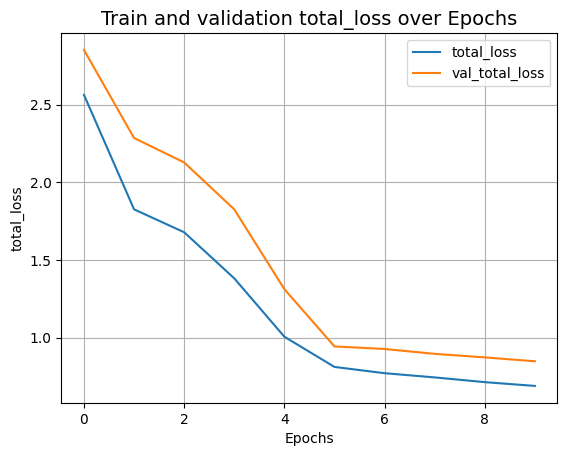

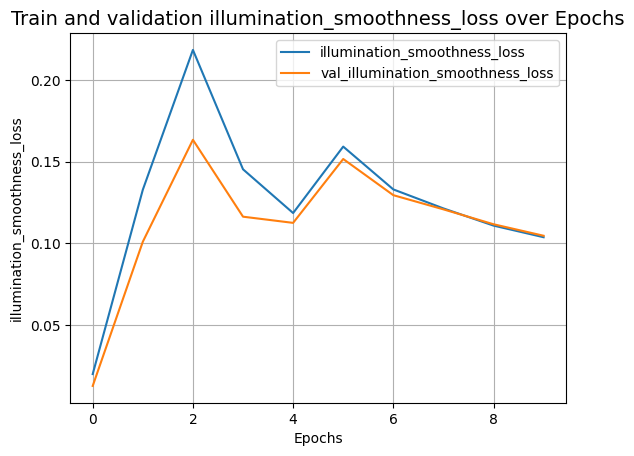

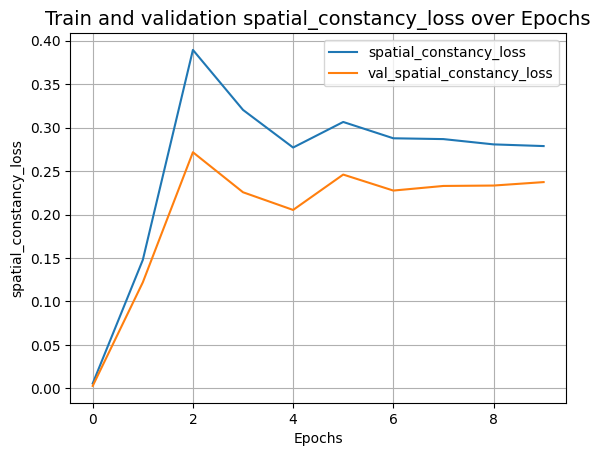

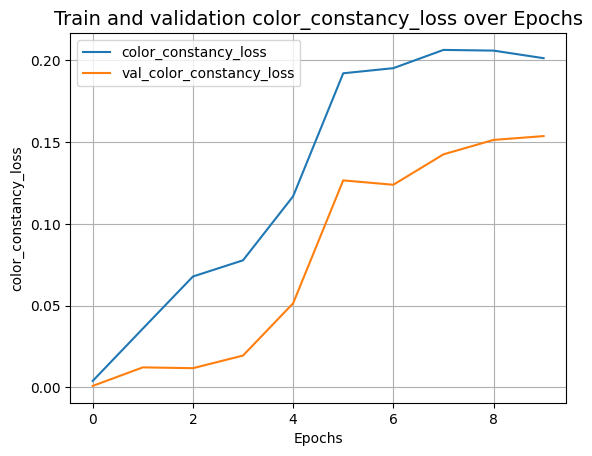

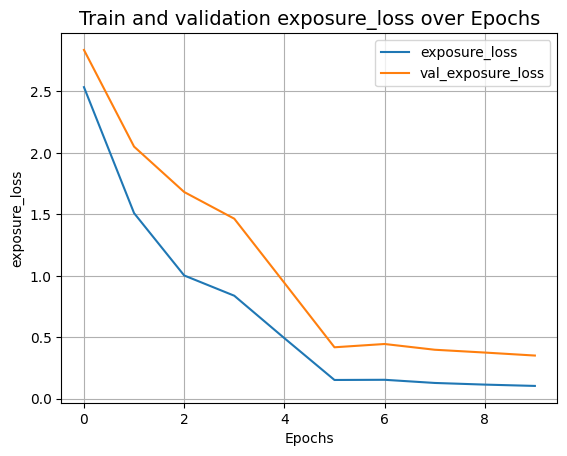

In [ ]:
def plot_result(item):
  plt.plot(history.history[item],label=item)
  plt.plot(history.history["val_"+item],label="val_"+item)
  plt.xlabel("Epochs")
  plt.ylabel(item)
  plt.title("Train and validation {} over Epochs".format(item),fontsize=14)
  plt.legend()
  plt.grid()
  plt.show()

plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

In [ ]:
def plot_result(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image


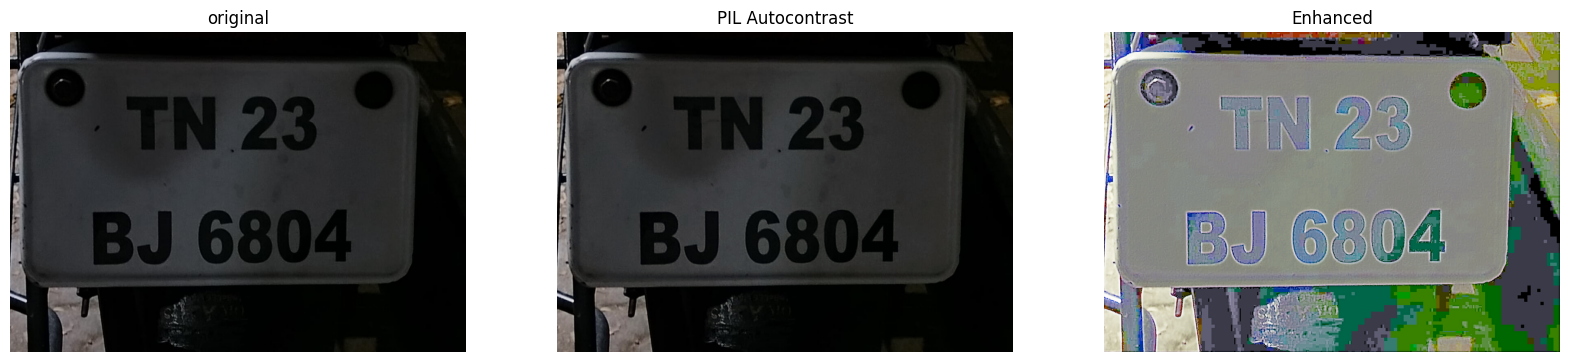

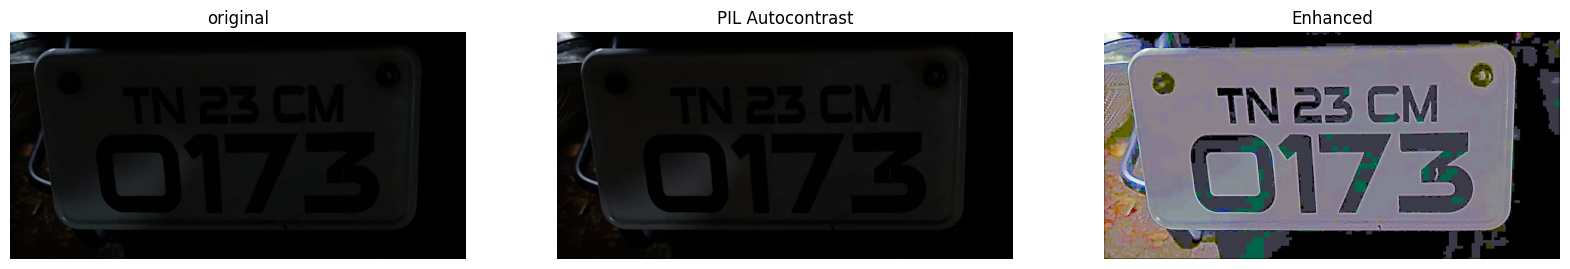

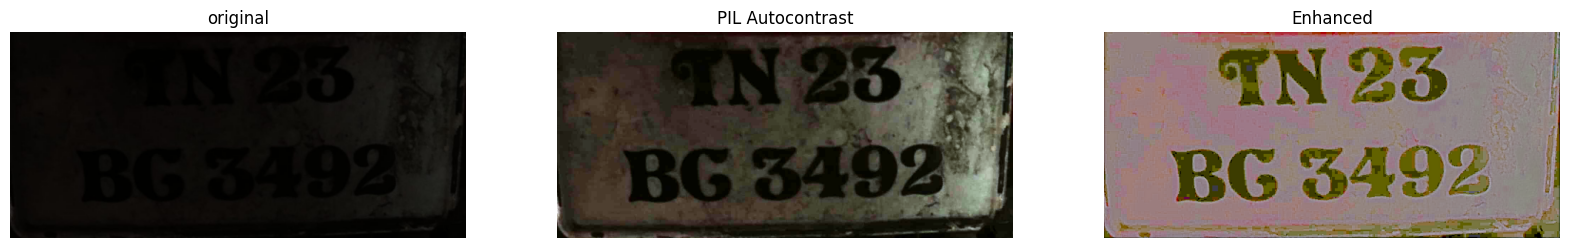

In [ ]:


test_low_light_images = sorted(glob("/content/drive/MyDrive/lol_dataset/lol_dataset/eval15/old_No_Plate/*"))
for val_image_file in test_low_light_images:
  original_image = Image.open(val_image_file)
  enhanced_image = infer(original_image)
  plot_result(
      [original_image, ImageOps.autocontrast(original_image),enhanced_image],
      ["original","PIL Autocontrast","Enhanced"],
      (20,12),
  )
#print(enhanced_images)

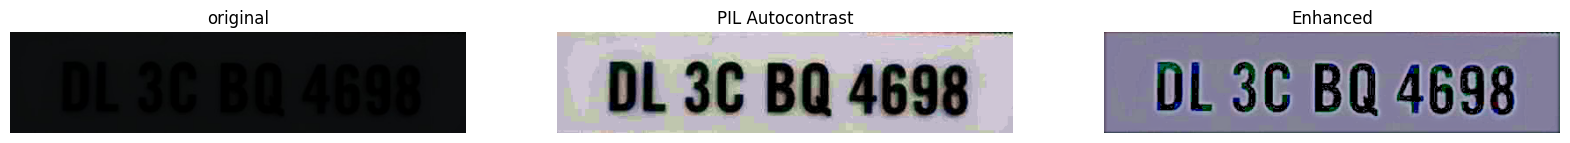

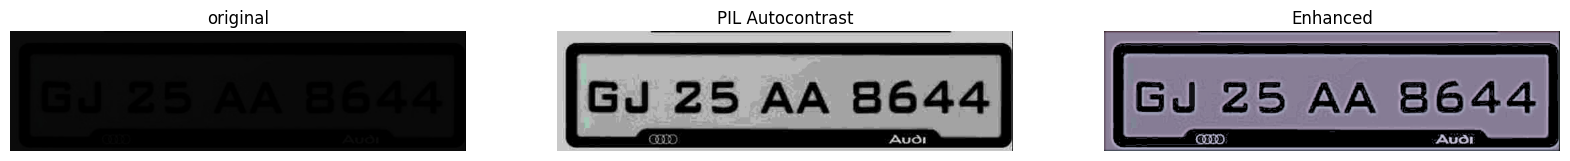

In [ ]:


test_low_light_images = sorted(glob("/content/drive/MyDrive/lol_dataset/lol_dataset/eval15/Set_test/*"))
enhanced_images = []
for val_image_file in test_low_light_images:
  original_image = Image.open(val_image_file)
  enhanced_image = infer(original_image)
  enhanced_images.append(enhanced_image)
  plot_result(
      [original_image, ImageOps.autocontrast(original_image),enhanced_image],
      ["original","PIL Autocontrast","Enhanced"],
      (20,12),
  )
  filename = os.path.basename(val_image_file)
  enhanced_image.save(os.path.join("/content/drive/MyDrive/lol_dataset/lol_dataset/eval15/enhanced", filename))
#print(enhanced_images)

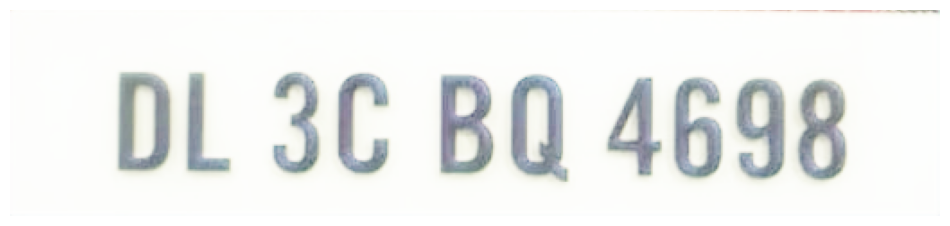

DL3CBO4698


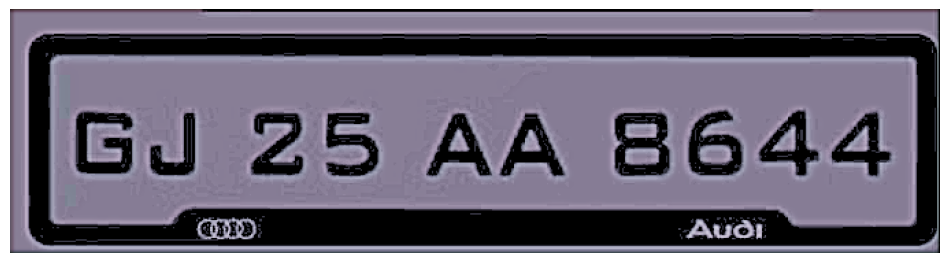

GWJ25AA8644


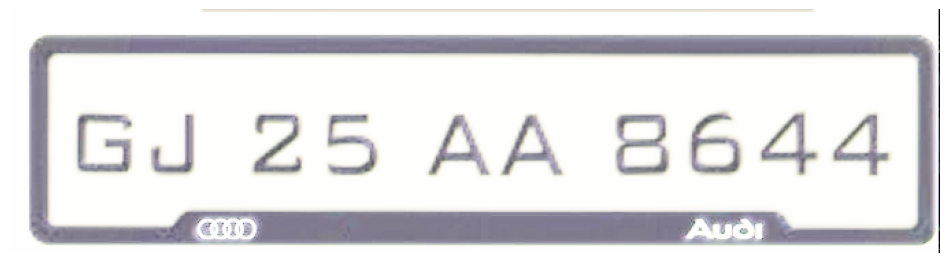

GJ25AA8644


In [ ]:

list_license_plates = []
predicted_license_plates = []
for img in enhanced_images:
    predicted_result = pytesseract.image_to_string(img, lang='eng', config='--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

    filter_predicted_result = "".join(predicted_result.split()).replace(":", "").replace("-", "")
    plot_result([img],[""])
    print(filter_predicted_result)
    predicted_license_plates.append(filter_predicted_result)

